# Adversarial examples : from CaffeNet to GoogleNet

Let's make some adversarial examples with CaffeNet, and see if some of them generalize to GoogleNet. The first part of this notebook (from the setup to the CaffeNet forward pass) is mostly taken from the caffe notebook CaffeNet classification.

## Building adversarial examples with CaffeNet

### 1. Setup

In [1]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline

#Set random seed
rnd.seed(42)

# set display defaults
plt.rcParams['image.interpolation'] = 'nearest'

* Load `caffe`.

In [2]:
import sys
caffe_root = '/home/pierre/caffe-master/'
sys.path.insert(0, caffe_root + 'python')

import caffe

* If needed, download the reference model ("CaffeNet", a variant of AlexNet).

In [3]:
import os
if os.path.isfile(caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'):
    print 'CaffeNet found.'
else:
    print 'Downloading pre-trained CaffeNet model...'
    cmd = caffe_root+'scripts/download_model_binary.py'
    target_net = caffe_root+'models/bvlc_reference_caffenet'
    !$cmd $target_net

CaffeNet found.


### 2. Load CaffeNet and set up input preprocessing

* Set Caffe to CPU mode because I have no GPU ^^

In [4]:
caffe.set_mode_cpu()

model_def = caffe_root + 'models/bvlc_reference_caffenet/deploy.prototxt'
model_weights = caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'

net = caffe.Net(model_def, model_weights, caffe.TEST)

* Set up input preprocessing

In [5]:
# load the mean ImageNet image (as distributed with Caffe) for subtraction
mu = np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy')
mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values
print 'mean-subtracted values:', zip('BGR', mu)

# create transformer for the input
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

mean-subtracted values: [('B', 104.0069879317889), ('G', 116.66876761696767), ('R', 122.6789143406786)]


### 3. Forward pass

* Now we're ready to perform classification ! We will classify 100 images randomly chosen in the [Caltech101](http://www.vision.caltech.edu/Image_Datasets/Caltech101/) dataset.

In [6]:
# set the size of the input
net.blobs['data'].reshape(100,        # batch size
                          3,         # 3-channel (BGR) images
                          227, 227)  # image size is 227x227

* Load the images and perform the preprocessing we've set up.

(-0.5, 299.5, 197.5, -0.5)

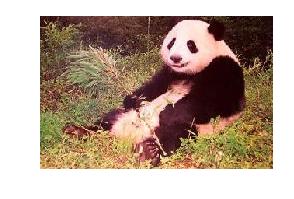

In [7]:
images = []
transformed_images = []
for i in xrange( net.blobs['data'].shape[0] ):
    image = caffe.io.load_image( "images/" + str( rnd.randint(0, 9145) ) + ".jpg" )
    images.append( image )
    transformed_images.append( transformer.preprocess('data', image) )

plt.rcParams['figure.figsize'] = (3, 3)
plt.imshow(images[0])
plt.axis('off')

* How likely was it to have a panda as first image by choosing the seed equal to 42 ?

In [8]:
# copy the image data into the memory allocated for the net
net.blobs['data'].data[...] = transformed_images

### perform classification
output = net.forward()

output_prob = output['prob'][0]  # the output probability vector for the first image in the batch

print 'predicted class is:', output_prob.argmax()

predicted class is: 388


* Let's check the ImageNet labels:

In [9]:
# load ImageNet labels
labels_file = caffe_root + 'data/ilsvrc12/synset_words.txt'
if not os.path.exists(labels_file):
    !../data/ilsvrc12/get_ilsvrc_aux.sh
    
labels = np.loadtxt(labels_file, str, delimiter='\t')

print 'output label:', labels[output_prob.argmax()]

output label: n02510455 giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca


* Correct! But let's also look at other top (but less confident predictions).

In [10]:
# sort top five predictions from softmax output
top_inds = output_prob.argsort()[::-1][:5]  # reverse sort and take five largest items

print 'probabilities and labels:'
zip(output_prob[top_inds], labels[top_inds])

probabilities and labels:


[(0.30480096,
  'n02510455 giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca'),
 (0.18686277, 'n02443114 polecat, fitch, foulmart, foumart, Mustela putorius'),
 (0.13331842, 'n02445715 skunk, polecat, wood pussy'),
 (0.068090044, 'n02443484 black-footed ferret, ferret, Mustela nigripes'),
 (0.039011247, 'n02447366 badger')]

* Let's save all the results before messing up with the input

In [11]:
r = output['prob'].argmax( axis = 1)

### 4. Adversarial examples building
* Now we will take the current predictions, and try to move away from them by imperceptibly changing the input images so that they are not recognized correctly anymore (or at least have different label predictions from the unmodified images ones).

* Backward pass. We compute:
$$ \frac{\partial E}{\partial i}(i, l) $$  
with $i$ the input and $l$ the current label prediction

In [12]:
# Current prediction
current_prediction = np.zeros( net.blobs['prob'].data.shape )
for i in xrange(len(r)) : current_prediction[i, r[i] ] = 1.0

# Set last layer difference equal to the error derivative with respect to the prediction
net.blobs['prob'].diff[:] = net.blobs['prob'].data[:] - current_prediction

# Backward pass
net.backward()

# Save error derivative with respect to the input
grad = net.blobs['data'].diff[:]

* Normalize the gradient and display a magnified version of the first image one:

(-0.5, 226.5, 226.5, -0.5)

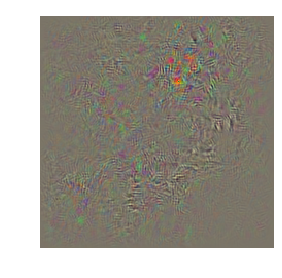

In [13]:
mean_norm = np.sqrt( np.sum(grad**2, axis = (1, 2, 3) ) / grad[0].size )
grad_dir = grad / mean_norm[:, None, None, None]

plt.rcParams['figure.figsize'] = (3, 3) 
plt.imshow( transformer.deprocess( 'data', 10.0*grad_dir[0] ) )
plt.axis('off')

* As in ["Explaining and harnessing adversarial examples"](https://arxiv.org/abs/1412.6572),  
we could also use:
$$ \text{sign}(\frac{\partial E}{\partial i}(i, l))$$

(-0.5, 226.5, 226.5, -0.5)

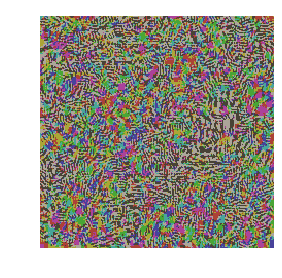

In [14]:
plt.rcParams['figure.figsize'] = (3, 3) 
plt.imshow( transformer.deprocess( 'data', 50.0*np.sign( grad_dir[0] ) ) )
plt.axis('off')

* Both method (plain gradient and sign) work. In what follows we will use the sign version:

In [15]:
perturbation = np.sign( grad_dir )

* Before messing up the inputs, we save the current inputs values:

In [16]:
p = net.blobs['data'].data[:].copy()

* We need the min and max values in each channel to replace pixels that are perturbated out of the limits:

In [17]:
mini = 0 - mu[None,:, None, None]
maxi = 255 - mu[None,:, None, None]

* Now we update the input images with our perturbation. Our perturbations are $\pm 2$, wich is small compare to the 255 range. We then proceed with a forward pass and store the results.

In [18]:
#Update input with perturbation
net.blobs['data'].data[:] = p + 2*perturbation
#Put back out of range pixels within limits
net.blobs['data'].data[:] = np.maximum( net.blobs['data'].data, mini)
net.blobs['data'].data[:] = np.minimum( net.blobs['data'].data, maxi)
#Forward pass
net.forward()
#Get results
rp = output['prob'].argmax( axis = 1)

* For display purpose we need smaller labels:

In [19]:
simple_labels = []
for l in labels:
    start = l.find(' ') + 1
    stop = l.find(',')
    if(stop != -1 ):
        simple_labels.append( l[start: stop] )
    else:
        simple_labels.append( l[start:] )

* We deprocess the inputs to display some of them and to later give them to GoogleNet. The original images are also deprocessed so that both have the same size.

In [20]:
untouched = []
messed_up = []
for i in xrange( net.blobs['data'].shape[0] ):
    untouched.append( transformer.deprocess( 'data', p[i] ) )
    messed_up.append( transformer.deprocess( 'data', net.blobs['data'].data[i] ) )

* We display the 5 first images. Top: original images with their predictions, middle: magnified perturbation, bottom: perturbated images with their new predictions:

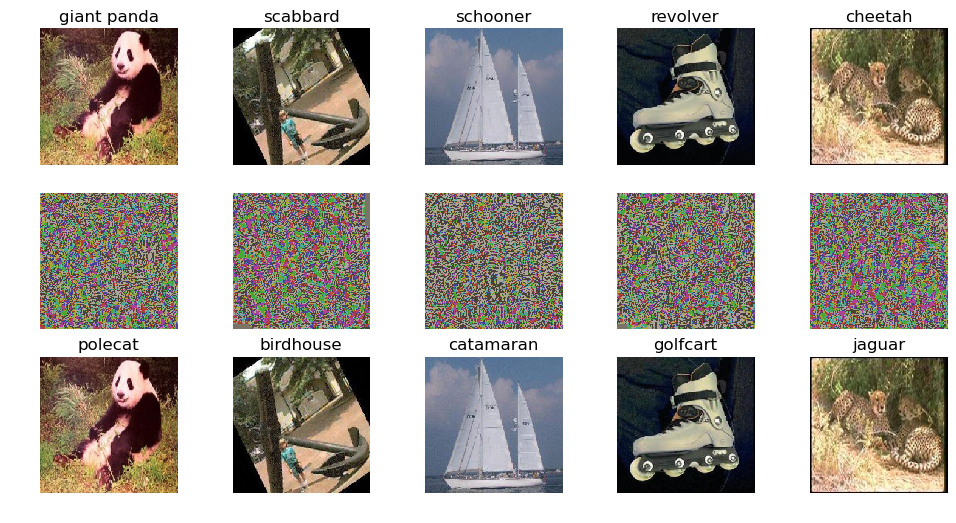

In [21]:
plt.rcParams['figure.figsize'] = (12, 6) 

f, sub = plt.subplots(3, 5)
for i in xrange( sub.shape[1] ):
    sub[0, i].imshow( untouched[i] )
    sub[0, i].set_title( simple_labels[ r[i] ] )
    sub[1, i].imshow( transformer.deprocess( 'data', 50*perturbation[i] ) )
    sub[2, i].set_title( simple_labels[ rp[i] ] )
    sub[2, i].imshow( messed_up[i] )
    
for s in sub.flat : s.set_axis_off()

* We can count how many images aren't given the same prediction before and after the perturbation:

In [22]:
rp = output['prob'].argmax( axis = 1)
print "Ratio of messed up predictions : ", np.sum(rp != r)/( 1.0 * len( r ) )

Ratio of messed up predictions :  0.98


98 images over 100 are now classified by CaffeNet with a different label !

## Classification of the perturbated images with GoogleNet  
* We now give both the perturbated an original images to GoogleNet to see how many of them are also given different predictions after the perturbation

### 1. Setup

In [23]:
import os
if os.path.isfile(caffe_root + 'models/bvlc_googlenet/bvlc_googlenet.caffemodel'):
    print 'GoogleNet found.'
else:
    print 'Downloading pre-trained GoogleNet model...'
    cmd = caffe_root+'scripts/download_model_binary.py'
    target_net = caffe_root+'models/bvlc_googlenet'
    !$cmd $target_net

GoogleNet found.


In [24]:
model_def = caffe_root + 'models/bvlc_googlenet/deploy.prototxt'
model_weights = caffe_root + 'models/bvlc_googlenet/bvlc_googlenet.caffemodel'

google_net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

In [25]:
google_net.blobs['data'].reshape(100,3,224, 224) 

In [26]:
# create transformer for the input called 'data'
google_transformer = caffe.io.Transformer({'data': google_net.blobs['data'].data.shape})

google_transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
google_transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
google_transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
google_transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

### 2. Preprocessing

In [27]:
google_transformed_untouched = []
google_transformed_messed_up = []
for i in xrange( google_net.blobs['data'].shape[0] ):
    google_transformed_untouched.append( google_transformer.preprocess('data', untouched[i]) )
    google_transformed_messed_up.append( google_transformer.preprocess('data', messed_up[i]) )

### 3. Classification

* Classification of original images:

In [28]:
google_net.blobs['data'].data[...] = google_transformed_untouched
google_r = google_net.forward()['prob'].argmax( axis = 1)

* Classification of perturbated images:

In [29]:
google_net.blobs['data'].data[...] = google_transformed_messed_up
google_rp = google_net.forward()['prob'].argmax( axis = 1)

* No we store indices of images with modified label predictions:

In [30]:
changed_predictions = np.argwhere(google_rp != google_r)[:, 0]

* Plots these images. Top: original images with their predictions, middle: magnified perturbation, bottom: perturbated images with their new predictions:

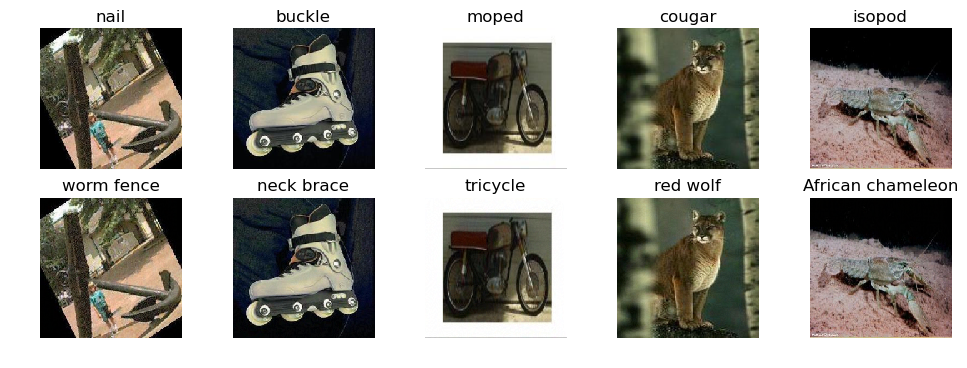

In [31]:
plt.rcParams['figure.figsize'] = (12, 4) 

f, sub = plt.subplots(2, 5)
for i in xrange( min(sub.shape[1], len(changed_predictions)) ):
    c = changed_predictions[i]
    
    sub[0, i].imshow( untouched[c] )
    sub[0, i].set_title( simple_labels[ google_r[c] ] )
    sub[1, i].set_title( simple_labels[ google_rp[c] ] )
    sub[1, i].imshow( messed_up[c] )
    
for s in sub.flat : s.set_axis_off()

* We can count how many images aren't given the same prediction before and after the perturbation:

In [32]:
print "Ratio of messed up predictions : ", np.sum(google_rp != google_r)/( 1.0 * len( google_r ) )

Ratio of messed up predictions :  0.08


Some (8%) of the images are now indeed classified by GoogleNet with a different label, despite having been built against CaffeNet !